In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FIG_PATH = "../results/figures"

# plt.rcParams["figure.figsize"] = (4.0, 3.0)
# plt.rcParams["figure.dpi"] = 150
# plt.rcParams["axes.spines.top"] = False
# plt.rcParams["axes.spines.right"] = False
# plt.rcParams["axes.grid"] = True
# plt.rcParams["grid.alpha"] = 0.3
# plt.rcParams["font.size"] = 9
# plt.rcParams["legend.frameon"] = False


In [20]:
tables_dir = os.path.join("..", "results", "tables")
exp10_path = os.path.join(tables_dir, "exp10_imagenet_adv_pier.csv")

df = pd.read_csv(exp10_path)
df.head()

,TargetModel,Group,Dose,MeanPIER
0,ResNet18,Standard CNN,0.00,4.552163
1,ResNet18,Standard CNN,0.02,4.476210
2,ResNet18,Standard CNN,0.04,4.404591
3,ResNet18,Standard CNN,0.06,4.349345
4,ResNet18,Standard CNN,0.08,4.295358


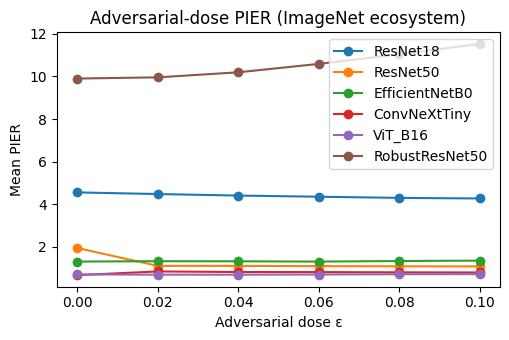

In [3]:
def plot_pier_dose_response(df: pd.DataFrame):
    """
    Plot PIER dose-response curves for all target models.
    """
    models = df["TargetModel"].unique().tolist()
    doses = sorted(df["Dose"].unique())

    plt.figure(figsize=(5.2, 3.5))

    for name in models:
        sub = df[df["TargetModel"] == name].sort_values("Dose")
        plt.plot(
            sub["Dose"].values,
            sub["MeanPIER"].values,
            marker="o",
            label=name,
        )

    plt.xlabel("Adversarial dose ε")
    plt.ylabel("Mean PIER")
    plt.title("Adversarial-dose PIER (ImageNet ecosystem)")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pier_dose_response(df)


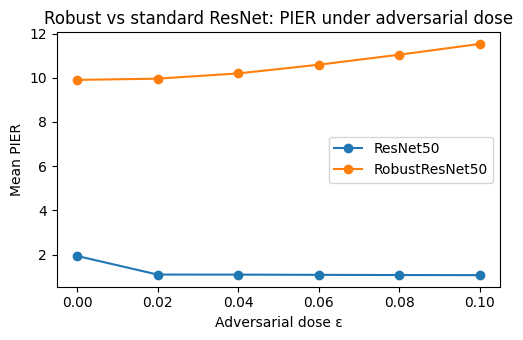

In [4]:
def plot_pier_robust_vs_standard(df: pd.DataFrame):
    """
    Plot PIER dose-response highlighting RobustResNet50 vs standard ResNet50.
    If RobustResNet50 is not present, this falls back to plotting all models.
    """
    models = df["TargetModel"].unique().tolist()

    if "RobustResNet50" in models and "ResNet50" in models:
        selected = ["ResNet50", "RobustResNet50"]
    else:
        selected = models

    plt.figure(figsize=(5.2, 3.5))
    for name in selected:
        sub = df[df["TargetModel"] == name].sort_values("Dose")
        plt.plot(
            sub["Dose"].values,
            sub["MeanPIER"].values,
            marker="o",
            label=name,
        )

    plt.xlabel("Adversarial dose ε")
    plt.ylabel("Mean PIER")
    plt.title("Robust vs standard ResNet: PIER under adversarial dose")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pier_robust_vs_standard(df)


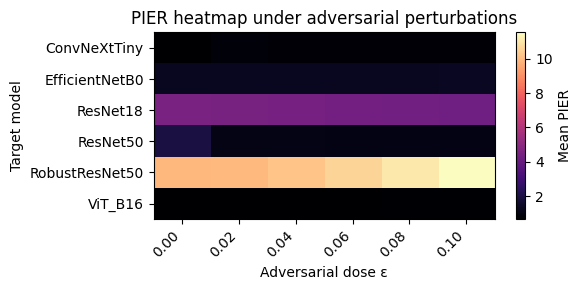

In [5]:
def plot_pier_heatmap(df: pd.DataFrame):
    """
    Plot a heatmap of MeanPIER (rows = models, columns = doses).
    """
    pivot = df.pivot_table(
        index="TargetModel",
        columns="Dose",
        values="MeanPIER",
        aggfunc="mean",
    )

    plt.figure(figsize=(6.0, 3.0))
    im = plt.imshow(pivot.values, aspect="auto", cmap="magma")

    plt.yticks(
        np.arange(len(pivot.index)),
        pivot.index,
    )
    plt.xticks(
        np.arange(len(pivot.columns)),
        [f"{d:.2f}" for d in pivot.columns],
        rotation=45,
        ha="right",
    )

    plt.xlabel("Adversarial dose ε")
    plt.ylabel("Target model")
    plt.title("PIER heatmap under adversarial perturbations")
    plt.colorbar(im, label="Mean PIER")
    plt.tight_layout()
    plt.show()


plot_pier_heatmap(df)


Saved: ../results/figures/imagenet_adv_landscape.pdf


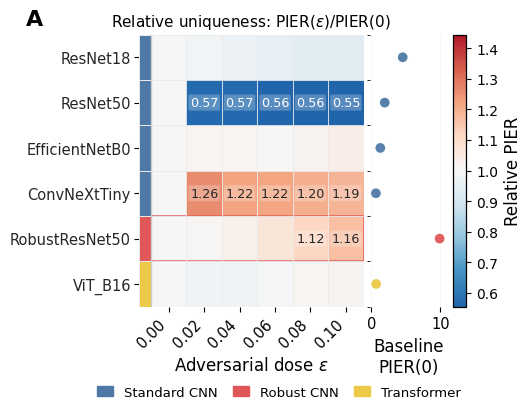

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

def _truncate_cmap(cmap, minval=0.08, maxval=0.92, n=256):
    """Trim colormap extremes to avoid over-saturation (more Nature-like)."""
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )

def plot_fig4A_imagenet_adv_landscape(df: pd.DataFrame, save_path: str = None):
    req = {"TargetModel", "Group", "Dose", "MeanPIER"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

    piv = df.pivot_table(
        index=["TargetModel", "Group"],
        columns="Dose",
        values="MeanPIER",
        aggfunc="mean",
    ).sort_index(axis=1)

    doses = list(piv.columns)
    base_dose = float(min(doses))
    baseline = piv[base_dose].copy()
    rel = piv.div(baseline.replace(0, np.nan), axis=0)

    meta = rel.reset_index()[["TargetModel", "Group"]].copy()
    meta["baseline"] = baseline.values

    preferred = ["Standard CNN", "Efficient CNN", "Modern CNN", "Vision Transformer", "Robust CNN"]
    groups = meta["Group"].unique().tolist()
    group_order = [g for g in preferred if g in groups] + [g for g in sorted(groups) if g not in preferred]
    meta["group_rank"] = meta["Group"].apply(lambda g: group_order.index(g))
    meta = meta.sort_values(["group_rank", "baseline"], ascending=[True, False])

    idx = list(zip(meta["TargetModel"], meta["Group"]))
    rel = rel.loc[idx]
    baseline = baseline.loc[idx]

    # -------------------------
    # Style (more Nature-like: lighter text, tighter lines)
    # -------------------------
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
    })

    # -------------------------
    # Premium muted group palette (colorblind-friendly, low saturation)
    # -------------------------
    GROUP_PALETTE = {
        "Standard CNN":        "#4E79A7",  # muted blue
        "Efficient CNN":       "#59A14F",  # muted green
        "Modern CNN":          "#9C755F",  # muted brown
        "Vision Transformer":  "#B07AA1",  # muted purple
        "Robust CNN":          "#E15759",  # muted red
    }
    # fallback for any extra groups
    fallback = ["#76B7B2", "#F28E2B", "#EDC948", "#AF7AA1", "#FF9DA7", "#8CD17D"]
    group_to_color = {}
    for i, g in enumerate(group_order):
        group_to_color[g] = GROUP_PALETTE.get(g, fallback[i % len(fallback)])

    strip_colors = [group_to_color[g] for g in meta["Group"]]

    # -------------------------
    # Heatmap colormap: truncated RdBu_r (less saturated, more print-friendly)
    # Also robust range: clip by percentiles to avoid a single outlier dominating.
    # -------------------------
    CMAP = _truncate_cmap(plt.get_cmap("RdBu_r"), 0.10, 0.90)

    rel_vals = rel.values.astype(float)
    finite = rel_vals[np.isfinite(rel_vals)]
    if finite.size == 0:
        raise ValueError("No finite values in relative PIER matrix.")

    p2, p98 = np.percentile(finite, [2, 98])
    # Make it symmetric around 1.0 so red/blue are comparable
    dev = max(abs(1.0 - p2), abs(p98 - 1.0))
    vmin, vmax = 1.0 - dev, 1.0 + dev
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=1.0, vmax=vmax)

    # -------------------------
    # Layout
    # -------------------------
    fig = plt.figure(figsize=(5.2, 4.0))
    gs = GridSpec(1, 3, width_ratios=[1.0, 0.34, 0.06], wspace=0.06)

    ax = fig.add_subplot(gs[0, 0])
    ax_base = fig.add_subplot(gs[0, 1], sharey=ax)
    cax = fig.add_subplot(gs[0, 2])


    # --- center heatmap ---
    im = ax.imshow(rel_vals, aspect="auto", cmap=CMAP, norm=norm)
    
    # --- annotate only meaningful deviations (cleaner, Nature-like) ---
    # threshold: only show numbers when |rel-1| >= 0.10 (tune: 0.08~0.15)
    thr = 0.10

    # choose text color by background intensity (auto contrast)
    # sample the colormap+norm for each cell; if "dark", use white text
    for r in range(rel.shape[0]):
        for c in range(rel.shape[1]):
            v = rel_vals[r, c]
            if not np.isfinite(v):
                continue
            if abs(v - 1.0) < thr:
                continue

            rgba = im.cmap(im.norm(v))
            # perceived luminance (0=dark, 1=bright)
            lum = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
            txt_color = "white" if lum < 0.55 else "0.15"

            ax.text(
                c, r, f"{v:.2f}",
                ha="center", va="center",
                fontsize=9.2,
                color=txt_color,
                zorder=10,
                bbox=dict(boxstyle="round,pad=0.12", facecolor="white", edgecolor="none", alpha=0.25)
            )

    # --- embedded group strip inside the heatmap axis (prettier than a separate ax) ---
    strip_w = 0.35  # width in "cell units" (0.25~0.45 looks good)

    # Extend x-limits to make room for the strip
    ax.set_xlim(-0.5 - strip_w, rel.shape[1] - 0.5)

    # Draw one colored rectangle per row
    for r, (m, g) in enumerate(rel.index):
        ax.add_patch(plt.Rectangle(
            (-0.5 - strip_w, r - 0.5), strip_w, 1.0,
            facecolor=group_to_color[g],
            edgecolor="0.92", linewidth=0.7,
            zorder=3
        ))

    # Vertical separator between strip and heatmap
    ax.axvline(-0.5, color="0.80", linewidth=1.0, zorder=4)

    ax.set_yticks(np.arange(rel.shape[0]))
    ax.set_yticklabels([m for (m, g) in rel.index])
    
    ax.tick_params(axis="y", pad=2)  # default often larger; 2~4 is clean

    ax.set_xticks(np.arange(rel.shape[1]))
    ax.set_xticklabels([f"{d:.2f}" for d in rel.columns], rotation=45, ha="right")
    ax.set_xlabel(r"Adversarial dose $\epsilon$")
    ax.set_title(r"Relative uniqueness: PIER$(\epsilon)$/PIER$(0)$", fontsize=11, pad=6)

    # separators (use light gray, not white, more “professional”)
    ax.set_xticks(np.arange(-0.5, rel.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rel.shape[0], 1), minor=True)
    ax.grid(which="minor", color="0.92", linestyle="-", linewidth=0.7, alpha=0.9)
    ax.tick_params(which="minor", bottom=False, left=False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
    for tick, (m, g) in zip(ax.get_yticklabels(), rel.index):
        tick.set_color("0.15")  # Keep consistent dark gray

    # highlight robust rows subtly
    for r, (m, g) in enumerate(rel.index):
        if ("robust" in m.lower()) or ("robust" in g.lower()):
            rect = plt.Rectangle((-0.5, r - 0.5), rel.shape[1], 1,
                                 fill=False, lw=1.2, ec=GROUP_PALETTE.get("Robust CNN", "#E15759"), alpha=0.85)
            ax.add_patch(rect)

    # --- right baseline dots (color by group, consistent with strip) ---
    y = np.arange(rel.shape[0])
    ax_base.scatter(
        baseline.values, y,
        s=62,
        c=strip_colors,
        alpha=0.95,
        edgecolor="white",
        linewidth=0.9,
        zorder=3
    )
    ax_base.grid(True, axis="x", linewidth=0.6, alpha=0.10)
    ax_base.set_axisbelow(True)
    ax_base.set_xlabel("Baseline\nPIER(0)")
    ax_base.set_xlim(left=-0.2, right=1.1 * baseline.max())
    ax_base.tick_params(axis="y", left=False, labelleft=False)
    for sp in ax_base.spines.values():
        sp.set_visible(False)

    # --- colorbar ---
    cb = fig.colorbar(im, cax=cax)
    cb.set_label("Relative PIER")
    cb.ax.tick_params(labelsize=10)

    # --- legend ---
    handles = []
    for g in group_order:
        if g in meta["Group"].values:
            handles.append(mpatches.Patch(color=group_to_color[g], label=g))

    fig.legend(
        handles=handles,
        frameon=False,
        ncol=3,
        fontsize=9.5,
        loc="lower center",
        bbox_to_anchor=(0.52, -0.02),
        columnspacing=1.2,
        handlelength=1.2,
    )

    fig.subplots_adjust(left=0.25, right=0.88, top=0.92, bottom=0.24)
    
    ax.text(-0.5, 1.02, "A", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

    if save_path is not None:
        fig.savefig(save_path)
        print(f"Saved: {save_path}")

    plt.show()
    return fig

plot_fig4A_imagenet_adv_landscape(
    df,
    save_path=os.path.join(FIG_PATH, "imagenet_adv_landscape.pdf")
);
